In [ ]:
from tensorflow.keras.layers import Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pandas as pd
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('/content/sample_data/formspring_data.csv',delimiter='\t',quoting=3)

In [ ]:
df = df[['ques','ans1']]  #limiting to question and answer 
#replacing html symbols
df['ques'] = df['ques'].str.replace('&#039;',' ')
df['ques'] = df['ques'].str.replace('&quot;',' ')
df['ques'] = df['ques'].str.replace('<br>',' ')    

In [ ]:
df = df.dropna()
positives = df[df['ans1']=='Yes']
negatives = df[df['ans1']=='No']
frames = [positives,negatives]

In [ ]:
df = pd.concat(frames)
df = df.sample(frac=1)

In [ ]:
df['ans1'] = df['ans1'].replace(('Yes','No'),(1,0))
bag = []
def clean_data(sentence):
    sentence = re.sub('[^a-zA-Z]',' ',sentence)
    sentence = sentence.lower().split()
    words = [word for word in sentence if not word in stopwords.words('english')]
    sentence = ' '.join(words)
    bag.append(sentence)

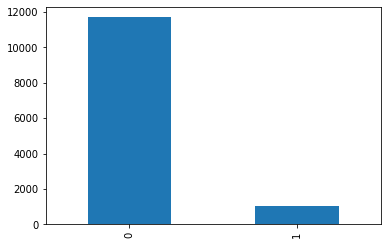

In [ ]:
df['ans1'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [ ]:
df['ans1'].value_counts()

0    11691
1     1038
Name: ans1, dtype: int64

In [ ]:
import re
df['ques'].apply(clean_data)

11360    None
5081     None
7931     None
8688     None
1370     None
         ... 
12458    None
8729     None
11548    None
3796     None
7642     None
Name: ques, Length: 12729, dtype: object

In [ ]:
tokenizer = Tokenizer(num_words=20000)

In [ ]:
X = df['ques'].values
tokenizer.fit_on_texts(X)
print(tokenizer.word_index)

{'you': 1, 'i': 2, 'a': 3, 'the': 4, 'to': 5, 'do': 6, 'what': 7, 'your': 8, 'is': 9, 'and': 10, 'it': 11, 'have': 12, 'in': 13, 'of': 14, 'u': 15, 'or': 16, 'are': 17, 'if': 18, 'would': 19, 'that': 20, 'like': 21, 'on': 22, 'me': 23, 'how': 24, 'be': 25, 'for': 26, 's': 27, 'ever': 28, 'my': 29, 'apos': 30, 'so': 31, 'why': 32, 'with': 33, 'who': 34, 'was': 35, 'think': 36, 'not': 37, 'r': 38, 'know': 39, 'lol': 40, 'when': 41, 't': 42, 'd': 43, 'love': 44, 'can': 45, 'one': 46, 'just': 47, 'about': 48, 'get': 49, 'but': 50, 'did': 51, 'up': 52, 'at': 53, '3': 54, 'this': 55, 'people': 56, 'im': 57, 'they': 58, 'go': 59, 'out': 60, 'ur': 61, 'all': 62, 'want': 63, 'were': 64, 'm': 65, 'there': 66, 'time': 67, 'someone': 68, 'now': 69, 'haha': 70, 'favorite': 71, 'had': 72, 'no': 73, 'from': 74, 'any': 75, 'as': 76, 'could': 77, 'p': 78, 'them': 79, 'last': 80, '39': 81, 'most': 82, 'say': 83, 'we': 84, 'been': 85, 'life': 86, 're': 87, 'person': 88, 'thing': 89, 'an': 90, 'her': 91, 

In [ ]:
len(tokenizer.word_index)
X = tokenizer.texts_to_sequences(X)
X = sequence.pad_sequences(X,maxlen=250)

In [ ]:
y = df['ans1'].values.astype(int)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [ ]:
model = Sequential()
model.add(Embedding(20000,120))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',f1_m,precision_m, recall_m])


In [ ]:
history = model.fit(X_train,y_train,batch_size=45,epochs=3,verbose=2,validation_data=(X_test,y_test))

Epoch 1/3
213/213 - 9s - loss: 0.3675 - accuracy: 0.9111 - f1_m: 0.3037 - precision_m: 0.2116 - recall_m: 2.9035 - val_loss: 0.2861 - val_accuracy: 0.9178 - val_f1_m: 0.3896 - val_precision_m: 0.3049 - val_recall_m: 0.6323
Epoch 2/3
213/213 - 9s - loss: 0.2844 - accuracy: 0.9189 - f1_m: 0.7793 - precision_m: 0.5880 - recall_m: 1.4060 - val_loss: 0.2849 - val_accuracy: 0.9179 - val_f1_m: 0.4589 - val_precision_m: 0.3393 - val_recall_m: 0.9799
Epoch 3/3
213/213 - 9s - loss: 0.2830 - accuracy: 0.9190 - f1_m: 0.9187 - precision_m: 0.6789 - recall_m: 1.8347 - val_loss: 0.2844 - val_accuracy: 0.9179 - val_f1_m: 0.4340 - val_precision_m: 0.3269 - val_recall_m: 0.9025


In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test,y_test,batch_size=45,verbose=2)

71/71 - 0s - loss: 0.2844 - accuracy: 0.9179 - f1_m: 0.4340 - precision_m: 0.3269 - recall_m: 0.9025


In [ ]:
test_sentence = ['You are a stupid bitch']

In [ ]:
y_pred = model.predict(X_test).reshape(3183,)

In [151]:
results = []
for x in y_pred:
  results.append(x[-1][0])

In [152]:
import numpy as np
results = np.array(results)

In [153]:
results

array([0.34558636, 0.54325897, 0.17992252, ..., 0.04320648, 0.2698784 ,
       0.3290717 ], dtype=float32)

In [155]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, results)

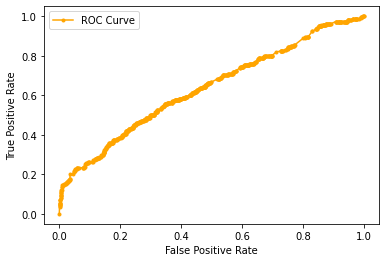

In [157]:
import matplotlib.pyplot as plt
plt.plot(fpr_keras, tpr_keras, marker='.', label='ROC Curve',color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()